## Imports

In [44]:
import os
import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import numpy as np
nltk.download("rslp");

[nltk_data] Downloading package rslp to /home/gus/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [53]:
plt.rcParams["font.size"] = 20 
plt.rcParams["font.weight"] = "bold"
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["figure.dpi"] = 300

In [54]:
plt.style.use("default")

### import modulos internos

In [50]:
sys.path.append("..")

In [55]:
from src.data.data_cleanner import DataCleanner
from src.data.text_preprocesser import TextPreprocessor
from src.data.time_converter import TimeConverter

### Importando as stopwords do NLTK

In [56]:
stopwords = nltk.corpus.stopwords.words('portuguese')

### Carregamento do dataset

In [57]:
df = pd.read_csv("../data/raw/NoThemeTweets.csv")

### Checando a quantidade de tweets positivos e negativos percebe-se que há o dobro de valores negativos, ou seja, nossa base de dados é desbalanceada.

In [58]:
df.sentiment.value_counts()

Negativo    522707
Positivo    263107
Name: sentiment, dtype: int64

### Eliminando tweets que tenham menos de 5 palavras

In [59]:
df = df.assign(
    number_words = df.tweet_text.apply(lambda x: len(x.split(" "))),
)  # adiciona coluna com número de palavras

df = df.drop(
     df[df.number_words < 5].index
 )  # remove tweets com menos de 5 palavras

### Elimimando tweets repetidos da nossa base de dados

In [60]:
df.drop_duplicates(["tweet_text"], inplace = True)

### Pegando uma amostragem de 70k tweets para fazermos a análise exploratória

In [61]:
df = df.sample(70000, random_state = 42)

In [62]:
df.head(5)

,id,tweet_text,tweet_date,sentiment,query_used,number_words
336150,1038219150861185024,@juliabruder o sea começa de tarde miga :( dep...,Sat Sep 08 00:15:09 +0000 2018,Negativo,:(,19
218325,1030528213729067008,Quero dormir mas não posso :(,Fri Aug 17 18:54:07 +0000 2018,Negativo,:(,6
140649,1030838137424171015,Me doa seus tênis que você não usa mais :( — P...,Sat Aug 18 15:25:38 +0000 2018,Negativo,:(,22
179949,1031980737992564738,@KauaniModesto poxa nega pensei q viesse me ve...,Tue Aug 21 19:05:55 +0000 2018,Negativo,:(,9
15242,1031360746012258305,"rapaz, não acabou não e eu tô indo dormir de n...",Mon Aug 20 02:02:18 +0000 2018,Positivo,:),12


### Remoção de caracteres especiais, menções de usuários e links

In [63]:
df["tweet_text"] = df.tweet_text.apply(
    lambda x: DataCleanner.format_text(x)
)# exclui links e menções


df["tweet_text"] = df.tweet_text.apply(
    lambda x: DataCleanner.remove_special_chars(x)
)# remove caracteres especiais

<h1 style="color:orangered">Geração de novos dados.</h1>

### Formatação da hora

In [64]:
df["date"] = df.tweet_date.apply(
    lambda time: TimeConverter.from_utc_to_local_time(time, -3)
)# custoso

In [65]:
df.drop(["tweet_date"], axis=1, inplace=True) # remoção de colunas desnecessárias

### Obtenção do período do dia

In [66]:
df["day_period"] = df.date.apply(
    lambda time: TimeConverter.get_day_period(time)
) # aqui é bala!

### Adição de uma coluna com a contagem do numero de caracteres por palavras

In [67]:
df = df.assign(
    avg_word_length=df.tweet_text.str.split()
    .apply(lambda x: [len(i) for i in x])
    .map(lambda x: np.mean(x))
)  # adiciona coluna com média de caracteres por palavra no tweet

In [68]:
# copia do dataframe para que não haja problemas ao manipularmos os dados originais
formated_df = df.copy()

## Informações sombre o dataframe.

In [69]:
print(df.shape)
print(formated_df.describe())

formated_df.sample(5)

(70000, 8)
                 id  number_words  avg_word_length
count  7.000000e+04  70000.000000     70000.000000
mean   1.038515e+18     14.605743         4.163107
std    5.523479e+15      9.982020         0.864393
min    1.029537e+18      5.000000         1.000000
25%    1.032425e+18      7.000000         3.666667
50%    1.039286e+18     11.000000         4.083333
75%    1.042928e+18     18.000000         4.555556
max    1.050785e+18     70.000000        68.500000


,id,tweet_text,sentiment,query_used,number_words,date,day_period,avg_word_length
193828,1032462191998513158,🖤 pra sempre branco e preto,Negativo,:(,8,2018-08-22 23:59:03+00:00,night,3.666667
586191,1042977282506162178,tu podia pegaar um salão de clube mais antigo...,Negativo,:(,39,2018-09-21 00:22:16+00:00,overnight,4.243243
297866,1037122996157247491,mano estão queimando toda a nossa história,Negativo,:(,8,2018-09-04 20:39:25+00:00,night,5.142857
349543,1038351391696269313,eu te amo você é tão lindo e importante,Negativo,:(,11,2018-09-08 06:00:38+00:00,morning,3.444444
739455,1046771737038389248,pior que essas mulheres tem de monte a maioria...,Negativo,:(,42,2018-10-01 11:40:04+00:00,morning,4.075000


## Histograma da quantidade de palavras nos tweets.
#### Nota-se claramente uma tendência dos tweets serem textos curtos, majoritariamente com menos de 20 palavras.

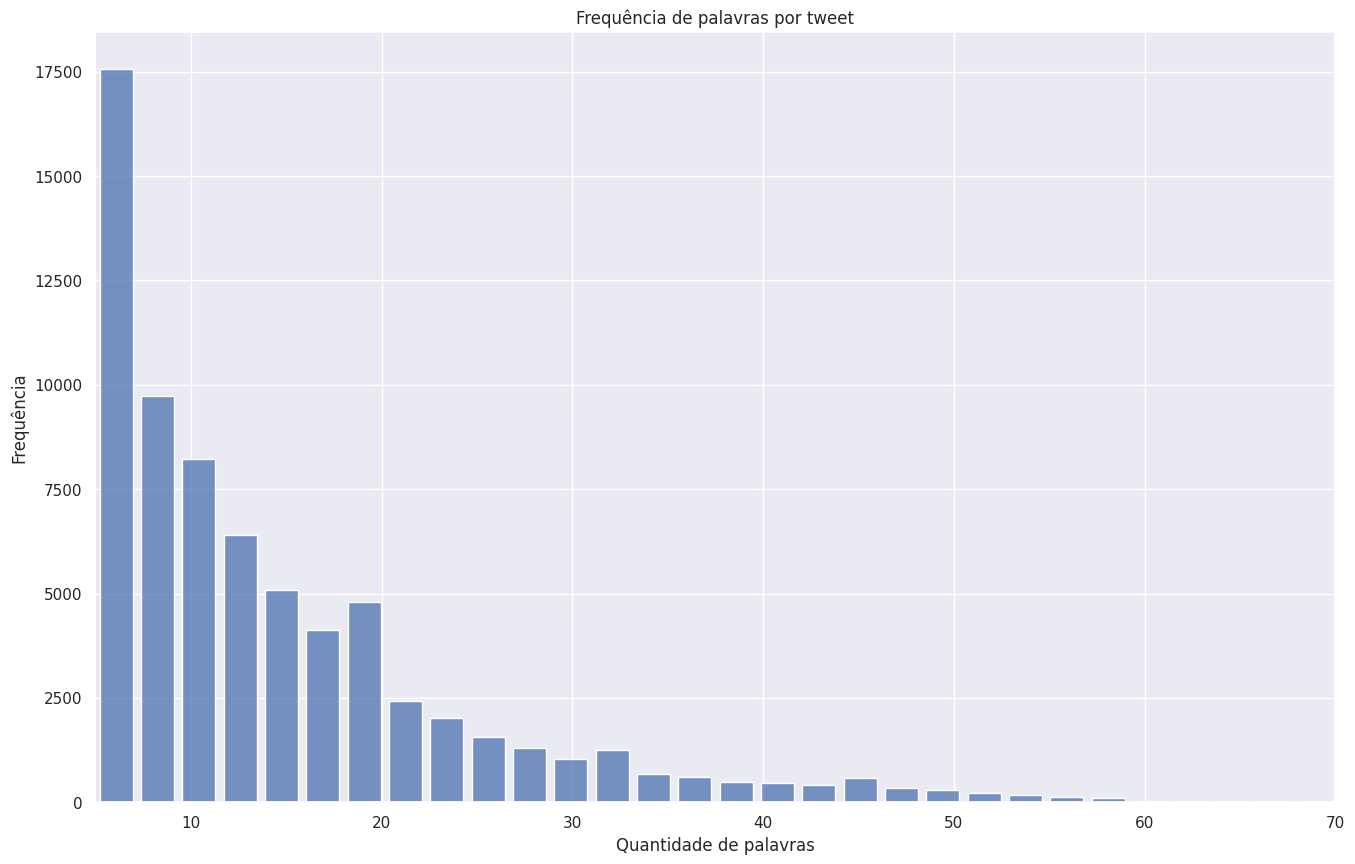

In [76]:
sns.set(rc={"figure.figsize": (16, 10)})
sns.histplot(data=formated_df, x="number_words", bins=30, shrink=0.8)

plt.xlabel("Quantidade de palavras")
plt.ylabel("Frequência")
plt.title("Frequência de palavras por tweet")
plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
# plt.savefig("/home/gus/Downloads/freq_palavras_por_tweets.jpg")
plt.show()

<h2 style="color:red"> Essa etapa sera desconsiderada no momento pois ja sabemos que a quantidade de tweets positivos é  menor que o de negativos</h2>

## Histograma da quantidade de palavras nos tweets separados por sentimentos.
#### Nota-se claramente uma tendência dos tweets negativos serem mais curtos, contudo no dataset a uma maior quantidade de tweets negativos, praticamente o dobro isso deve ser considerado. Logo, a tendência seria que  os tweets negativos fossem cerca duas vezes em quantidade, contudo os tweets menores são ligeiramente maiores que o dobro, logo a uma leve tendência de tweets menores serem mais negativos.

In [20]:
# sns.set(rc={"figure.figsize": (12, 8)})
# sns.histplot(
#     data=formated_df,
#     x="number_words",
#     hue="sentiment",
#     bins=30,
#     palette={"Positivo": "green", "Negativo": "red"},
#     multiple="dodge",
#     shrink=0.8,h"].m
# )
# plt.xlabel("Quantidade de palavras")
# plt.ylabel("Frequência")
# plt.title("Frequência de palavras por tweet de acordo com o sentimento")
# plt.xlim(formated_df.number_words.min(), formated_df.number_words.max())
# plt.show()

## Tamanho médio das palavras em cada tweet

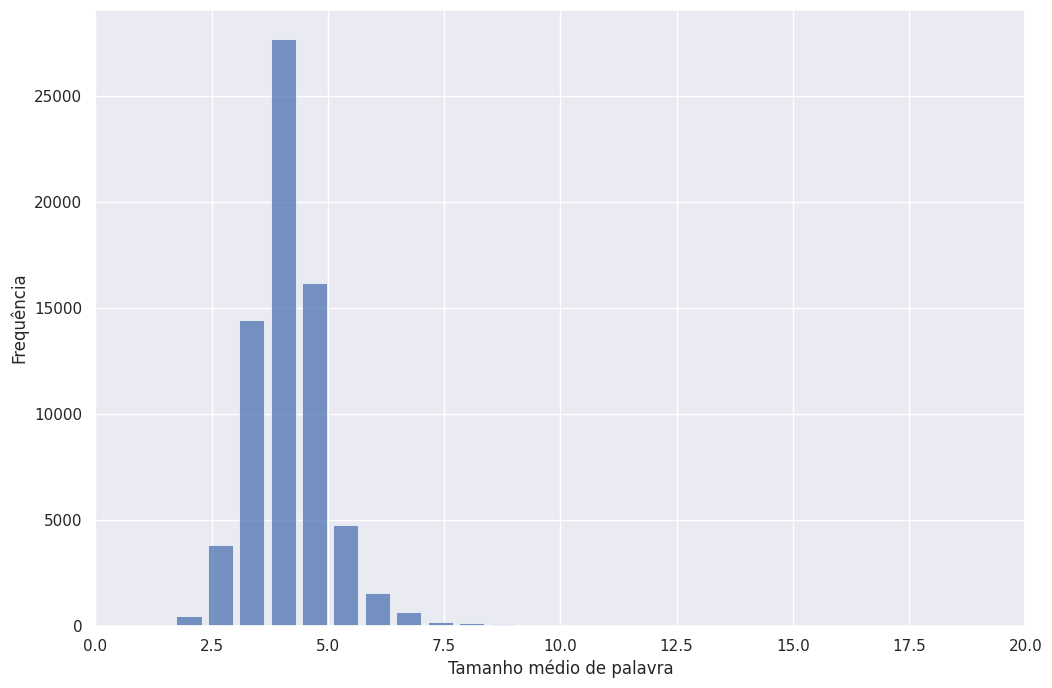

In [71]:
sns.set(rc={"figure.figsize": (12, 8)})

sns.histplot(data=formated_df, x="avg_word_length", bins=100, shrink=0.8)
plt.xlabel("Tamanho médio de palavra")
plt.ylabel("Frequência")
plt.xlim(0, 20)
plt.show()

## Separação dos dataframes em positivo e negativo e criação do corpus

In [72]:
df_positivo = formated_df.query("sentiment == 'Positivo'")
df_negativo = formated_df.query("sentiment == 'Negativo'")
df_all = formated_df

positive_text = " ".join(df_positivo.tweet_text)
negative_text = " ".join(df_negativo.tweet_text)
all_text = " ".join(df_all.tweet_text)

## Quantidade de tweets por período do dia.

#### Nota-se claramente que há uma maior quantidade de tweets de noite, provavelmente nos outros horários as pessoas estão ou trabalhando, estudando ou dormindo.

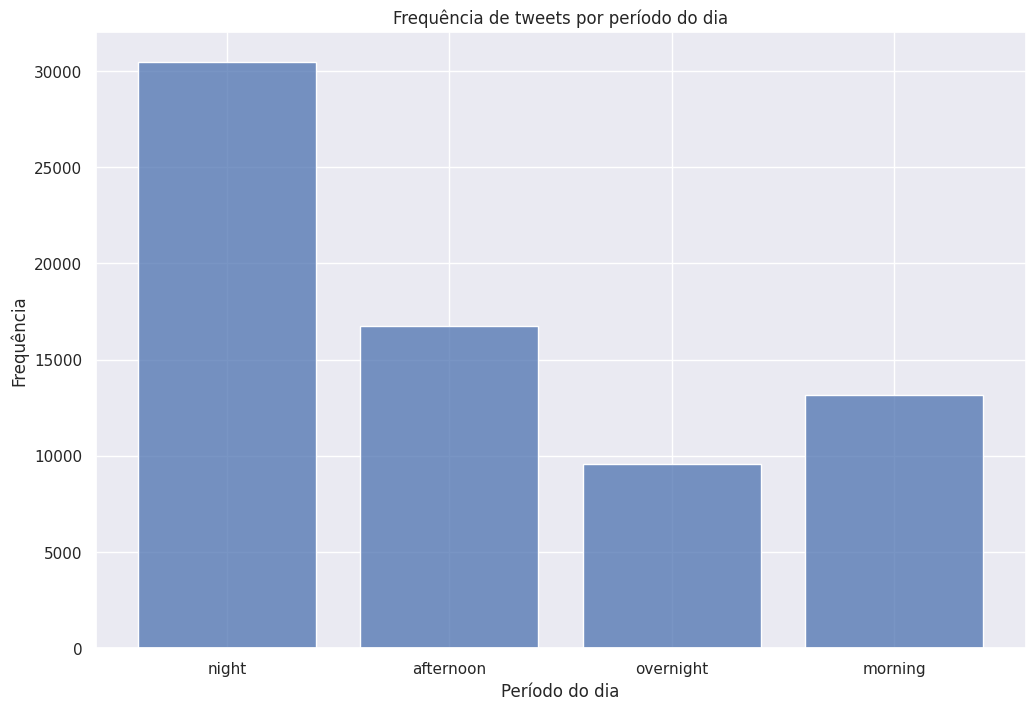

In [73]:
sns.histplot(data=formated_df, x="day_period", bins=5, shrink=0.8)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período do dia")
plt.show()

### Plotagem da quantidade de tweets positivos vs negativos por período do dia
#### podemos observar que a quantidade de tweets negativos é sempre maior que a de positivos em qualquer período do dia, essa proporção de 2 para 1 foi observada nas etapas anteriores e é explicada pelo desbalanceamento nos dados, no entanto, a noite essa proporção aparenta ser um pouco maior.

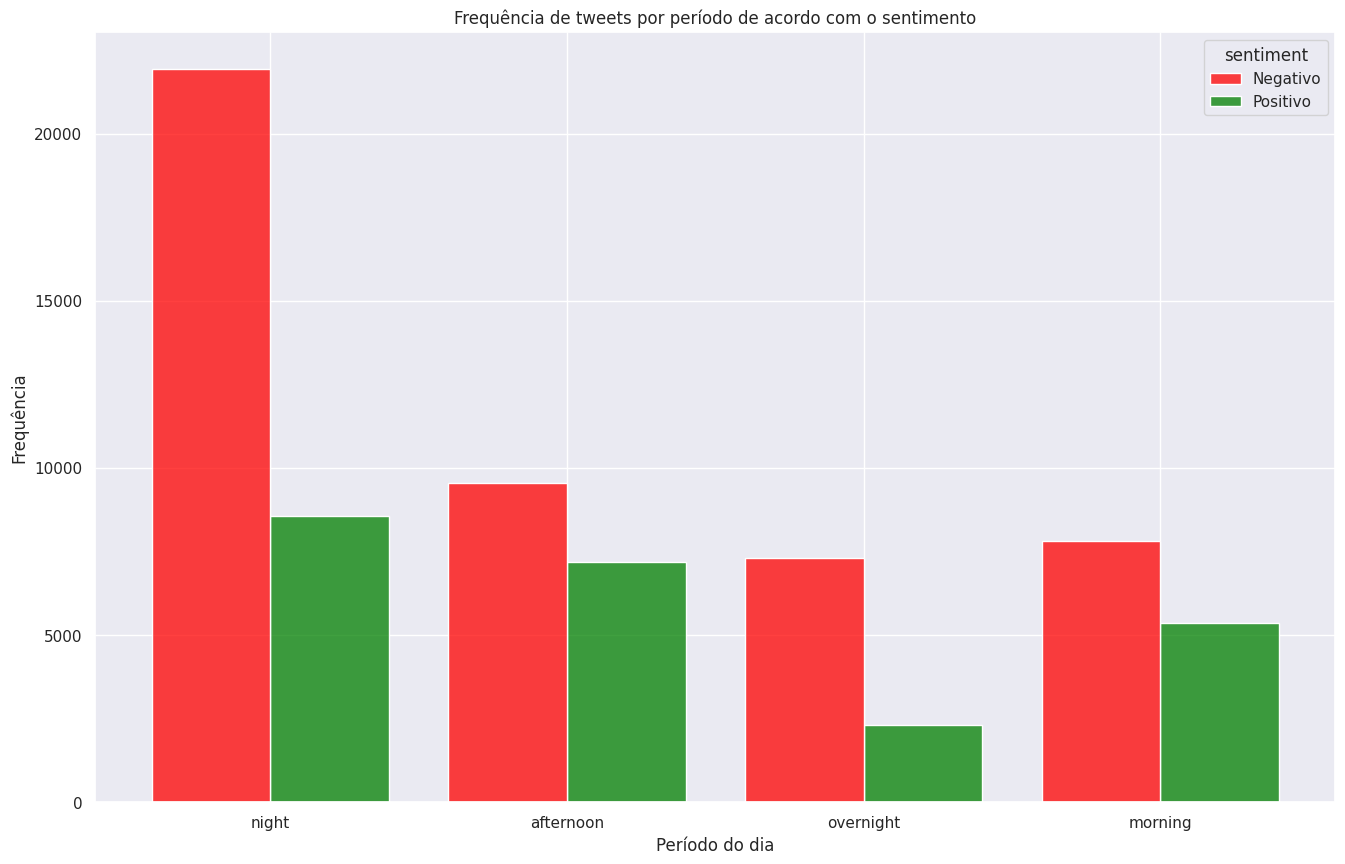

In [77]:
sns.histplot(
    data=formated_df,
    x="day_period",
    hue="sentiment",
    bins=5,
    palette={"Positivo": "green", "Negativo": "red"},
    multiple="dodge",
    shrink=0.8,
)
plt.xlabel("Período do dia")
plt.ylabel("Frequência")
plt.title("Frequência de tweets por período de acordo com o sentimento")
# plt.savefig("/home/gus/Downloads/tweets_por_periodo_do_dia.jpg")
plt.show()

<h2 style="color:purple">Parte 2 - Criação do Corpus e verificação das Principais Stopwords</h2>

### Cria os top 50 stop words que mais aparecem no corpus

analyzed stopwords:
 ['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'ao', 'ele', 'das', 'à', 'seu', 'sua', 'ou', 'quando', 'muito', 'nos', 'já', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'numa', 'pelos', 'elas', 'qual', 'nós', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivesse

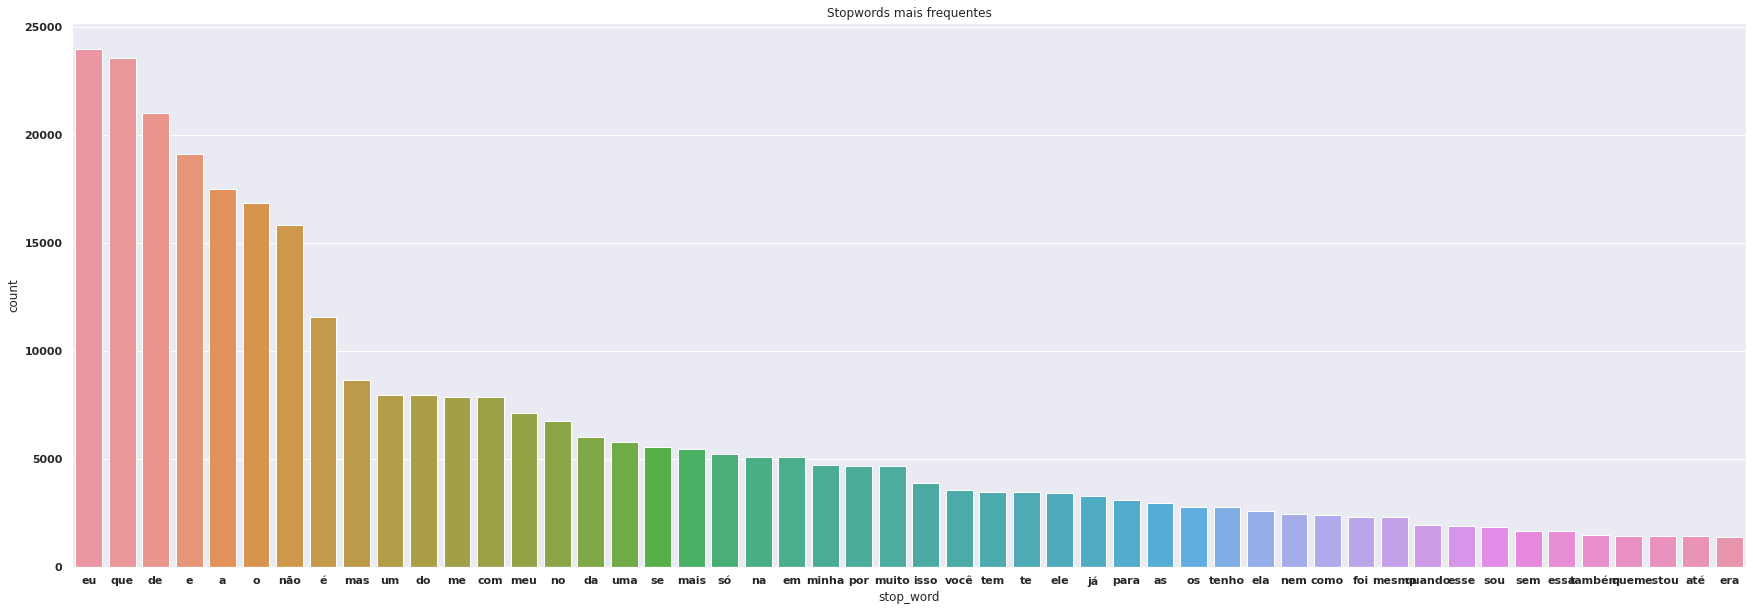

In [30]:
from collections import defaultdict

dic = defaultdict(int)

# stopwords = nltk.corpus.stopwords.words("portuguese")

print("analyzed stopwords:\n", stopwords)


for word in (all_text).split():
    if word in stopwords:
        dic[word] += 1


top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes")
plt.show()

### Plot das top 10 palavras mais frequentes

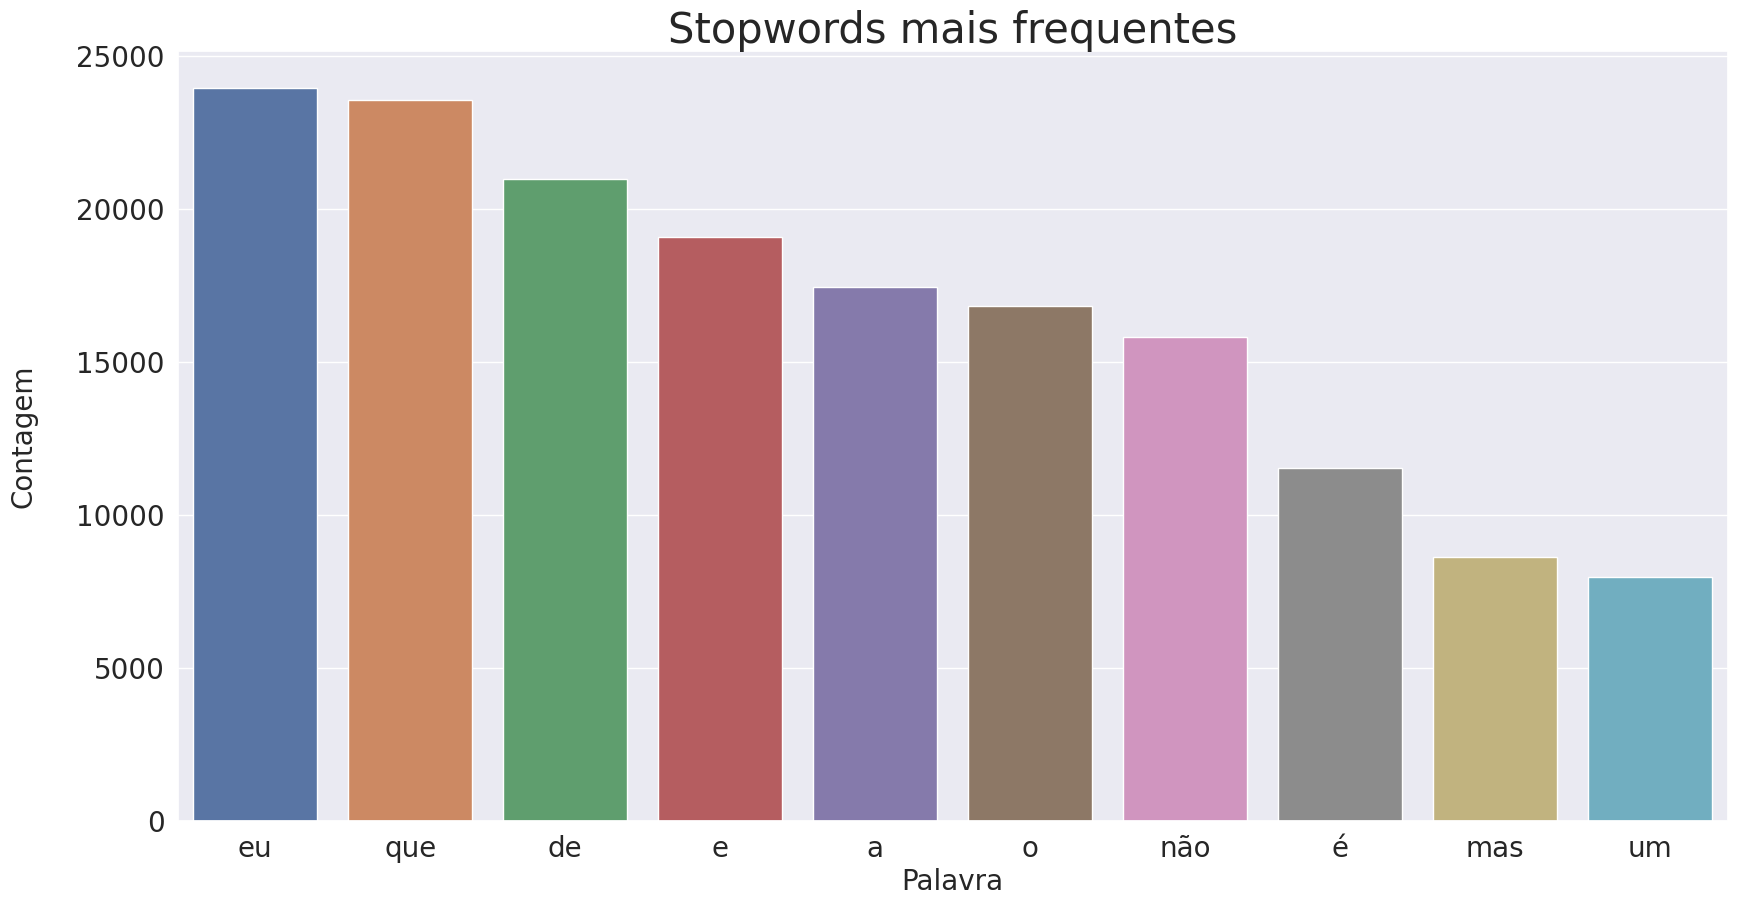

In [41]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df.iloc[0:10])

plt.ylabel("Contagem\n",fontsize=20)
plt.xlabel("Palavra", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.title("Stopwords mais frequentes", fontsize=30)
plt.savefig("/home/gus/Downloads/top10-stopwords.jpg", dpi=300)
plt.show()

### O nltk considera como stop words algumas palavras que podem conter cunho sentimental, por conta disso essas palavras serão removidas desse vetor.

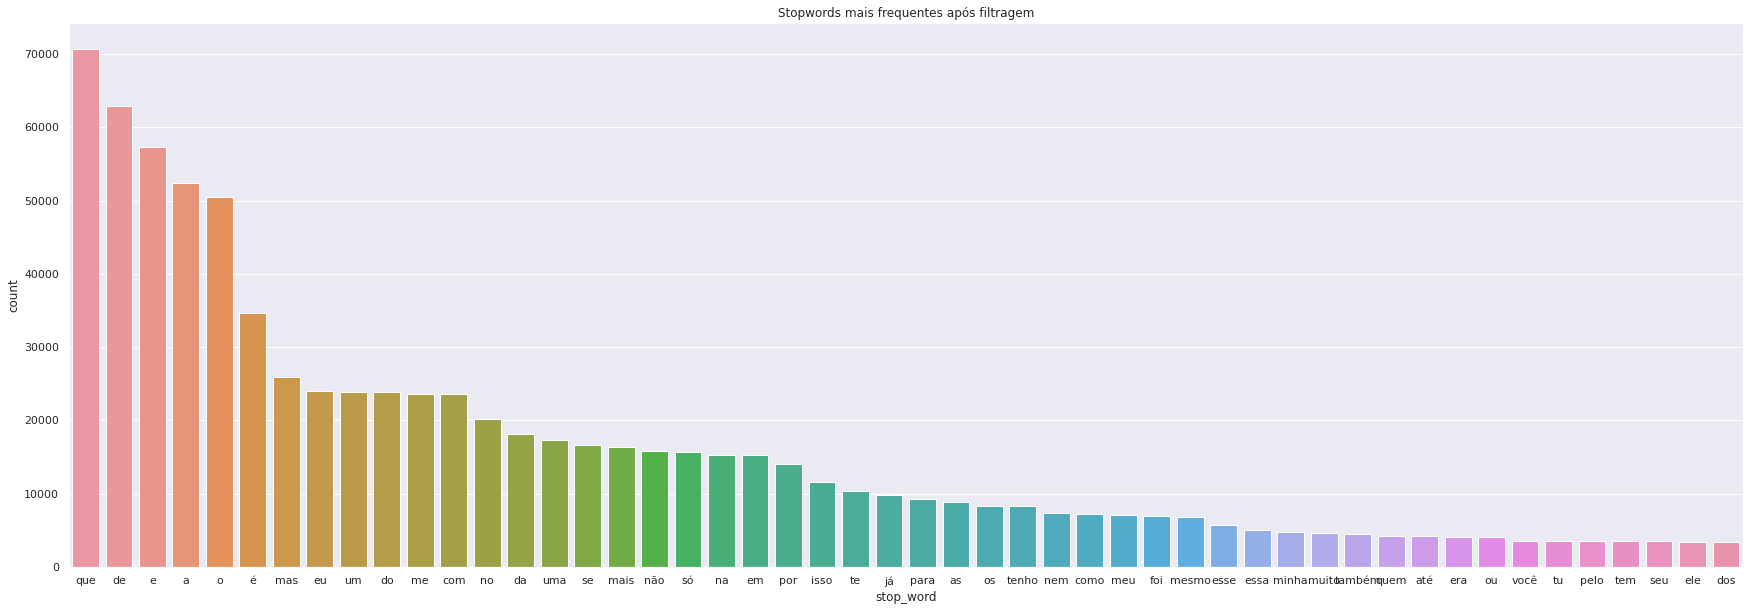

In [27]:
relevant_stop_words = [
    "eu",
    "não",
    "meu",
    "minha",
    "muito",
    "você",
    "tem",
    "ele",
    "ela",
    "quando",
    "sou",
    "você",
    "sem",
    "estou",
]  # stopwords consideradas relevantes para análise de sentimento, serão mantinidas em todo o processo de análise
stopwords = list(
    filter(lambda x: x not in relevant_stop_words, stopwords)
)  # remove do conjunto de stopwords palavras que não serão consideradas para filtragem

for word in all_text.split():
    if word in stopwords:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:50]  # top 50 stopwords


stopwords_df = pd.DataFrame(top, columns=["stop_word", "count"])


sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="stop_word", y="count", data=stopwords_df)
plt.title("Stopwords mais frequentes após filtragem")
plt.show()

## Análise das palavras mais frequentes que não são stop words.

#### Nota-se que há várias expressões e abreviações comuns  na internet e na língua portuguesa.

[('eu', 23966), ('que', 23558), ('de', 20989), ('e', 19107), ('a', 17470), ('o', 16836), ('não', 15828), ('é', 11548), ('mas', 8650), ('um', 7973), ('do', 7948), ('me', 7849), ('com', 7842), ('pra', 7598), ('meu', 7111), ('no', 6746), ('da', 6027), ('uma', 5763), ('se', 5553), ('mais', 5437), ('só', 5236), ('na', 5099), ('em', 5080), ('q', 5028), ('minha', 4720), ('por', 4687), ('muito', 4672), ('queria', 4572), ('to', 4195), ('vou', 3909), ('isso', 3874), ('você', 3565), ('tem', 3485), ('te', 3452), ('ele', 3403), ('vai', 3375), ('já', 3272), ('para', 3079), ('vc', 3024), ('d', 2963), ('as', 2952), ('n', 2928), ('bem', 2925), ('ter', 2797), ('dia', 2776), ('os', 2767), ('tenho', 2763), ('pq', 2750), ('triste', 2666), ('p', 2647), ('tá', 2634), ('ser', 2599), ('ela', 2590), ('nem', 2450), ('como', 2401), ('amo', 2347), ('tô', 2337), ('tudo', 2327), ('agora', 2326), ('ver', 2311), ('foi', 2306), ('nao', 2306), ('mesmo', 2283), ('tão', 2247), ('gente', 2199), ('quero', 2195), ('fazer', 2

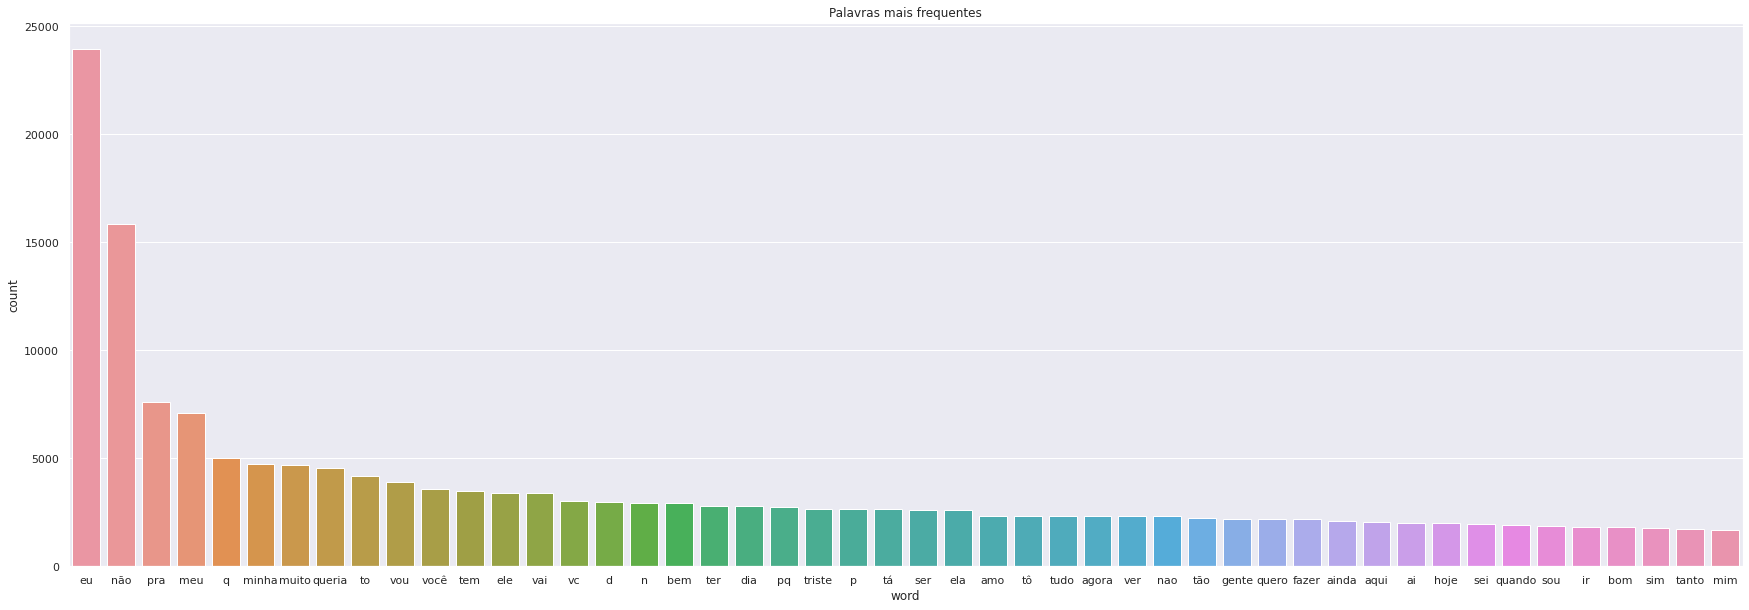

In [28]:
from collections import Counter


counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)

most_common_words = list(zip(x, y))

most_common_words_df = pd.DataFrame(
    most_common_words, columns=["word", "count"]
)  # cria um dataframe com as palavras mais frequentes

sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_df)
plt.title("Palavras mais frequentes")
plt.show()

## Adiciona stopwords com palavras ou símbolos não relevantes para análise, descoberto com os gráficos anteriores.

In [29]:
invalid_terms = [
    "p",  # indentificava apenas como "p"
    "d",  # indentificava apenas como "d"
    "(",
    "pra",
    "q",
    "_",
    "((",
    "pq",
    "ai",
    "D",
    "P",
]  # palavras inrelevantes para análise de sentimento, ou termos abreviados já contidos em stopwords

stopwords.extend(invalid_terms)

counter = Counter(all_text.split())
most = counter.most_common(80)
print(most)
print(len(most))

x, y = [], []
for word, count in most:
    if word not in stopwords:
        x.append(word)
        y.append(count)


most_common_words_filtered = list(zip(x, y))

most_common_words_filtered_df = pd.DataFrame(
    most_common_words_filtered, columns=["word", "count"]
)

[('eu', 23966), ('que', 23558), ('de', 20989), ('e', 19107), ('a', 17470), ('o', 16836), ('não', 15828), ('é', 11548), ('mas', 8650), ('um', 7973), ('do', 7948), ('me', 7849), ('com', 7842), ('pra', 7598), ('meu', 7111), ('no', 6746), ('da', 6027), ('uma', 5763), ('se', 5553), ('mais', 5437), ('só', 5236), ('na', 5099), ('em', 5080), ('q', 5028), ('minha', 4720), ('por', 4687), ('muito', 4672), ('queria', 4572), ('to', 4195), ('vou', 3909), ('isso', 3874), ('você', 3565), ('tem', 3485), ('te', 3452), ('ele', 3403), ('vai', 3375), ('já', 3272), ('para', 3079), ('vc', 3024), ('d', 2963), ('as', 2952), ('n', 2928), ('bem', 2925), ('ter', 2797), ('dia', 2776), ('os', 2767), ('tenho', 2763), ('pq', 2750), ('triste', 2666), ('p', 2647), ('tá', 2634), ('ser', 2599), ('ela', 2590), ('nem', 2450), ('como', 2401), ('amo', 2347), ('tô', 2337), ('tudo', 2327), ('agora', 2326), ('ver', 2311), ('foi', 2306), ('nao', 2306), ('mesmo', 2283), ('tão', 2247), ('gente', 2199), ('quero', 2195), ('fazer', 2

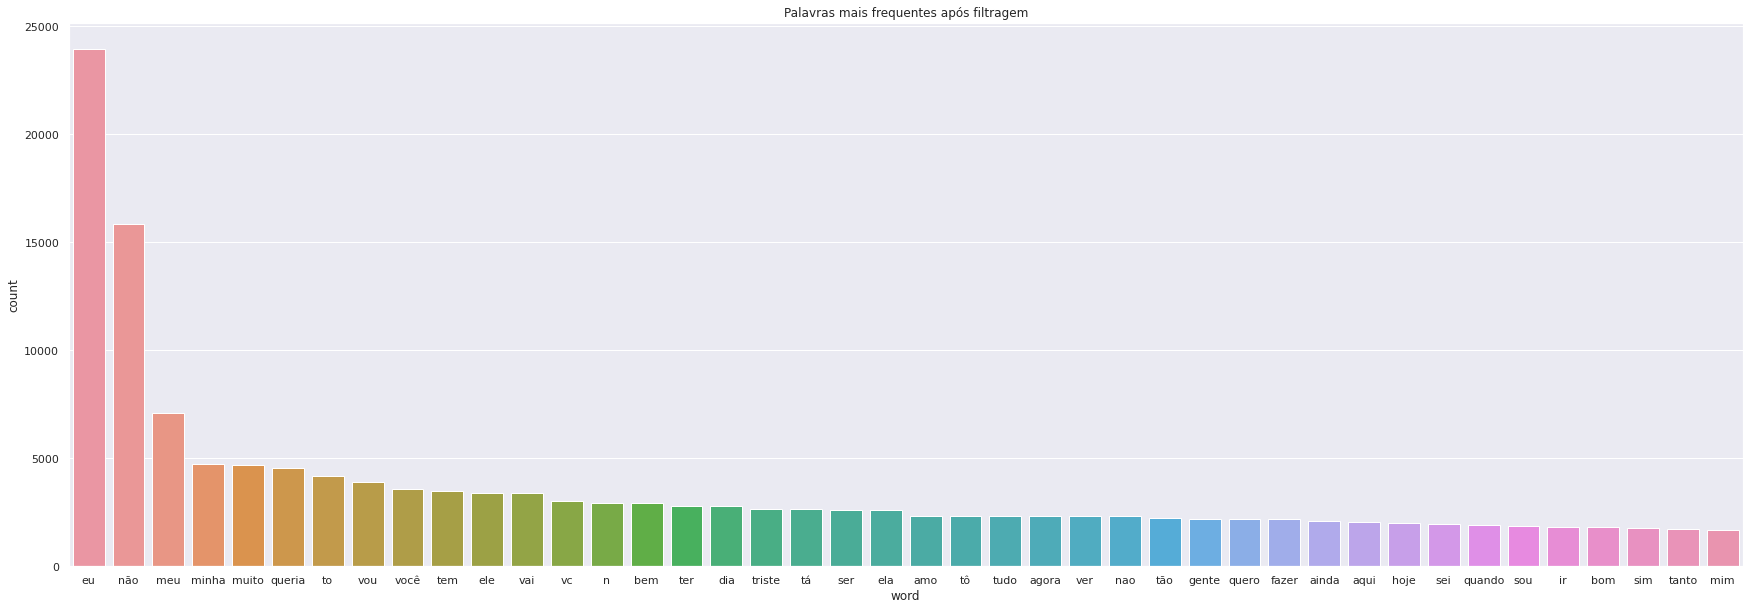

In [29]:
sns.set(rc={"figure.figsize": (30, 10)})
sns.barplot(x="word", y="count", data=most_common_words_filtered_df)
plt.title("Palavras mais frequentes após filtragem")
plt.show()

## Utilizando as análises anteriores é definido um conjunto final de stop words que é utilizada para filtrar todos os corpus
<h4 style="color:red"> Essas stopwords importantes serão salvas em um arquivo .txt na pasta data/processed para o uso em etapas futuras</h4>

In [30]:
with open("../data/processed/stopwords.txt", "a") as file:
    for word in stopwords:
        file.write(word)
        file.write("\n")
    file.close()

#### Liberação de espaço na memória

In [31]:
del df, df_all, file

### Remoção das stopwords e criação dos Corpus

In [57]:
final_stop_words = stopwords

positive_filter = TextPreprocessor.remove_stop_words(positive_text, final_stop_words)
negative_filter = TextPreprocessor.remove_stop_words(negative_text, final_stop_words)
all_text_filter = TextPreprocessor.remove_stop_words(all_text, final_stop_words)

# Plotagem das palavras mais comuns em cada um dos corpus após remoção das Stopwords

### Texto completo

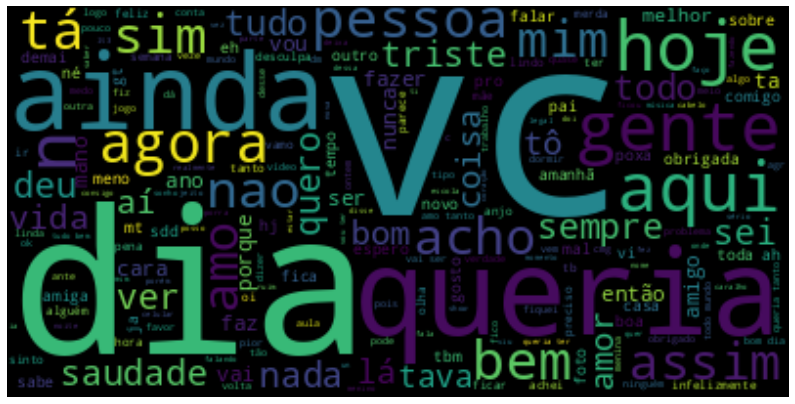

In [58]:
wordcloud = WordCloud().generate(all_text_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Texto Positivo

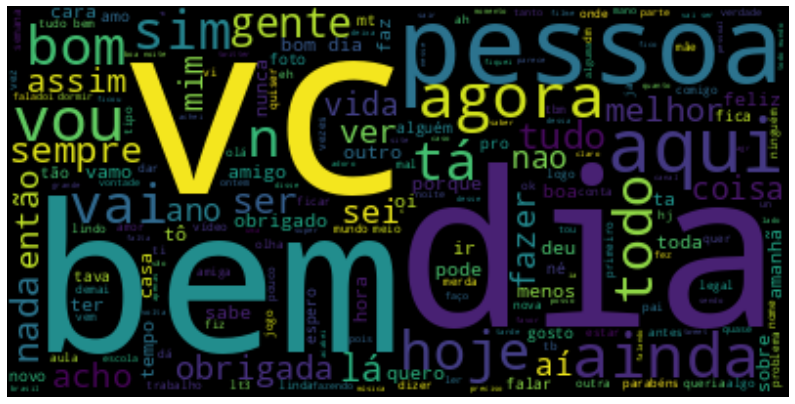

In [37]:
# Generate a word cloud image
wordcloud = WordCloud().generate(positive_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Texto Negativo

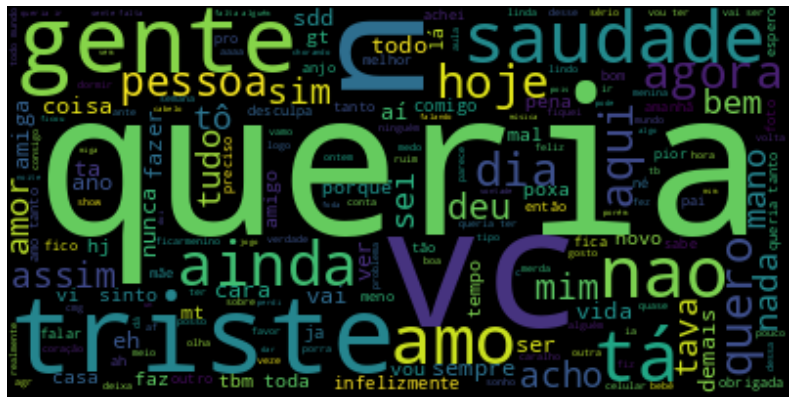

In [38]:
wordcloud = WordCloud().generate(negative_filter)
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos radicais mais comuns no Texto Completo após remoção de stopwords e apliação de stemming

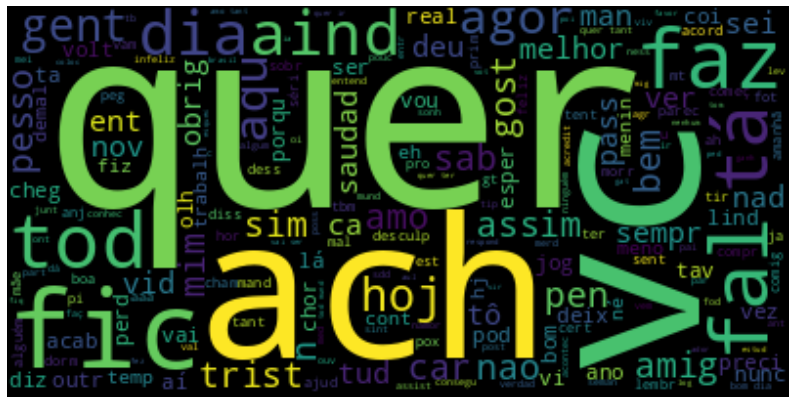

In [39]:
wordcloud = WordCloud().generate(TextPreprocessor.stemming(all_text_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos radicais mais comuns no Texto Positivo após remoção de stopwords e apliação de stemming

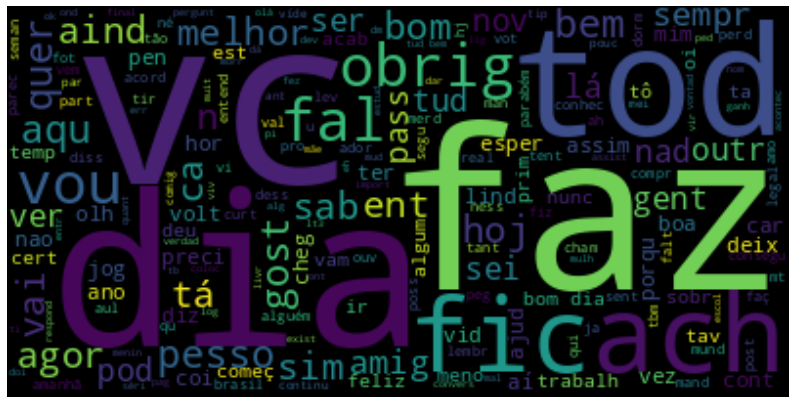

In [40]:
wordcloud = WordCloud().generate(TextPreprocessor.stemming(positive_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Plotagem visual dos radicais mais comuns no Texto Negativo após remoção de stopwords e apliação de stemming

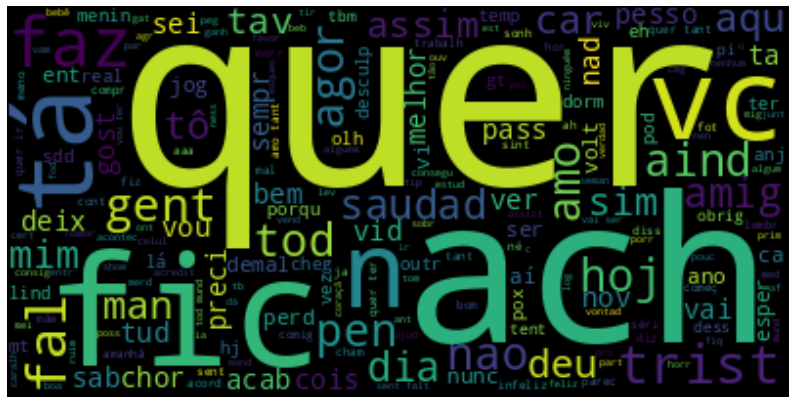

In [41]:
wordcloud = WordCloud().generate(TextPreprocessor.stemming(negative_filter))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos lemas mais comuns no Texto Completo após remoção de stopwords e apliação de Lematização

In [33]:
df_full = pd.concat([df_positivo, df_negativo])

In [34]:
df_full.drop(["id","query_used","number_words",
              "date","day_period","avg_word_length"],
             axis=1, inplace = True)

df_full.head(5)

,tweet_text,sentiment
15242,rapaz não acabou não e eu tô indo dormir de no...,Positivo
262963,vais ser tu ou o flávio,Positivo
719555,entende que vc é feia e ninguém nunca vai se i...,Positivo
25283,tenho te visto por ponte de lima pareces super...,Positivo
514705,ano que vem eu vou a um jogo no arruda,Positivo


### Remoção de stopwords para lematização

In [35]:
df_full["tweet_text"] = df_full.tweet_text.apply(
    lambda tweet: TextPreprocessor.remove_stop_words(tweet, final_stop_words)
)

### Lematização do texto

In [36]:
lemmatized_full_text = df_full.tweet_text.apply(
    lambda tweet: TextPreprocessor.lemmatization(tweet)
)

## Separação dos textos positivos e negativos


In [40]:
lemmatized_positive_text = lemmatized_full_text[df_full.sentiment == "Positivo"]
lemmatized_negative_text = lemmatized_full_text[df_full.sentiment == "Negativo"]

## Plot do texto completo lematizado e sem stopwords

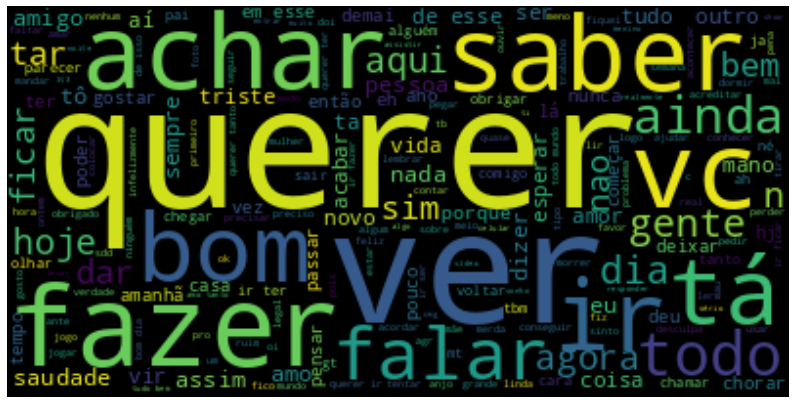

In [39]:
wordcloud = WordCloud().generate(" ".join(lemmatized_full_text))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos lemas mais comuns no Texto Positivo após remoção de stopwords e apliação de Lematização

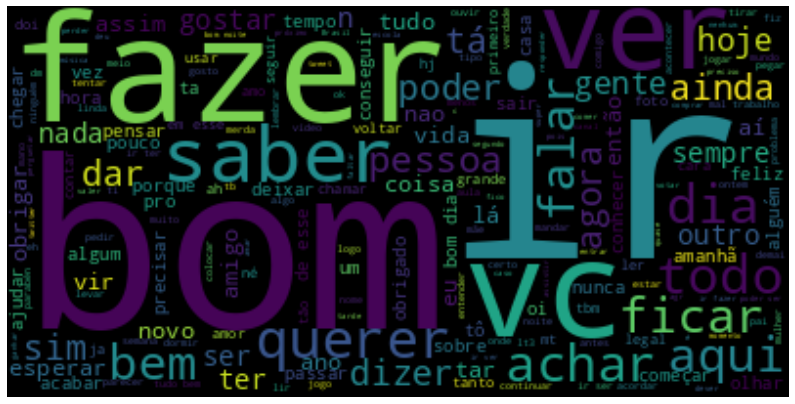

In [42]:
wordcloud = WordCloud().generate(" ".join(lemmatized_positive_text))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plotagem visual dos lemas mais comuns no Texto Negativo após remoção de stopwords e apliação de Lematização

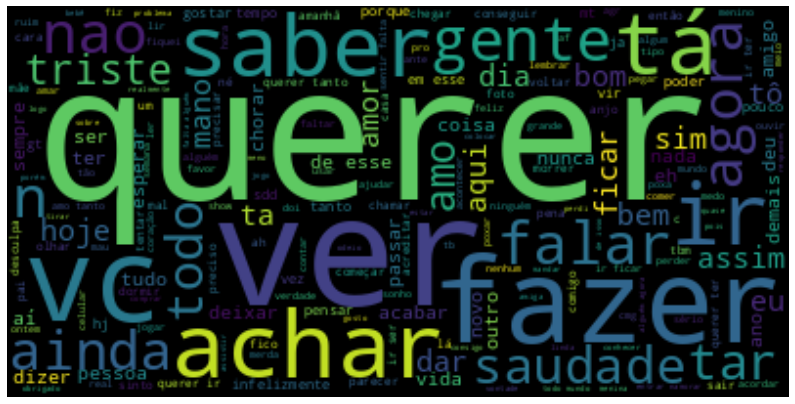

In [43]:
wordcloud = WordCloud().generate(" ".join(lemmatized_negative_text))
plt.figure(figsize=(14, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Analise dos ngram mais comuns nos corpus.

## Há uma recorrencial de ngrams com termos como "gt", "it","amp" que não consegui identificar o que significam. Além disso há presença de muitas datas de notícias importante que aconteceram na época, e que as pessoas comentaram na época.

In [55]:
# top_2_gram = get_top_ngram(all_text_filter.split(), gram_size=2, top_gram=20 )


# top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])

# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_2_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [56]:
# top_3_gram = get_top_ngram(all_text_filter.split(), gram_size=3, top_gram=20)


# top_3_gram_df = pd.DataFrame(top_3_gram, columns=["ngram", "count"])


# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_3_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [57]:
# top_2_gram = get_top_ngram(positive_filter.split(), gram_size=2, top_gram=20 )

# top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_2_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [58]:
# top_2_gram = get_top_ngram(negative_filter.split(), gram_size=2, top_gram=20 )

# top_2_gram_df = pd.DataFrame(top_2_gram, columns=["ngram", "count"])


# sns.set(rc={"figure.figsize": (30, 10)})
# sns.barplot(x="ngram", y="count", data=top_2_gram_df)
# plt.title("Ngram mais frequentes após filtragem")
# plt.show()

In [36]:
# whos

,id,tweet_text,sentiment,query_used,number_words,date,day_period,avg_word_length
15242,1031360746012258305,rapaz não acabou não e eu tô indo dormir de no...,Positivo,:),12,2018-08-19 23:02:18+00:00,night,3.250000
262963,1036590803819352064,vais ser tu ou o flávio,Positivo,:),8,2018-09-03 09:24:41+00:00,morning,3.000000
719555,1045354497684512770,entende que vc é feia e ninguém nunca vai se i...,Positivo,:),24,2018-09-27 13:48:28+00:00,afternoon,3.952381
25283,1031077431275335680,tenho te visto por ponte de lima pareces super...,Positivo,:),21,2018-08-19 04:16:30+00:00,overnight,4.000000
514705,1041689911303262209,ano que vem eu vou a um jogo no arruda,Positivo,:),12,2018-09-17 11:06:43+00:00,morning,2.900000


### Salvando a versão final dos dados limpos após a adição das coluna: numero de palavras, day_period e avg_word_length

In [37]:
# df_positivo.to_csv("../data/clean-dataset/tweets-positivos-final.csv", sep="\t", index=False)
# df_negativo.to_csv("../data/clean-dataset/tweets-negativos-final.csv", sep="\t", index=False)